# Amplitude and Phase

The goal of this notebook is to read an interferogram image (i.e., 2-D array of phase values) and unwrap it. Phase unwrapping is a critical process in interferometry, which involves recovering unambiguous phase data from the interferogram.

A SAR interferogram represents the phase difference between two radar acquisitions (i.e., two SLC images). The phase difference is usually wrapped within a range of 0 to 2π, because phase is inherently cyclical. When the true phase difference exceeds 2π, it gets "wrapped" into this range, creating a discontinuous phase signal. Phase unwrapping refers to the process of reconstructing the continuous phase field from the wrapped phase data.

Unwrapping an interferogram is essential for extracting correctly information contained in the phase such as surface topography and earth surface deformations.

There are many approaches that tried to solve the unwrapping problem, tackling challenging scenarios involving noise or large phase discontinuities. Here we present the Network-flow Algorithm for Phase Unwrapping approach (C. W. Chen and H. A. Zebker, 2000), which is implemented in the SNAPHU package.

## Loading the data
The data is stored on the Jupyterhub server, so we need to load it using their respective paths.

In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import xarray as xr
from pathlib import Path
import cmcrameri as cmc
import snaphu

In [3]:
# Define the paths to the data
user = Path.home().name
path = rf"/mnt/c/Users/{user}/mrs-data/multilooking_and_filtering"
filename_origin = ("S1A_IW_SLC__1SDV_20230129T033452_20230129T033519"
                   + "_046993_05A2FE_BE0B_Orb_Stack_IW3_ifg_deb_dinsar"
                   + "_ML_flt_Cnv.tif")
filename_lowcoh = ("S1A_IW_SLC__1SDV_20230129T033452_20230129T033519"
                   + "_046993_05A2FE_BE0B_Orb_Stack_IW3_ifg_deb_dinsar"
                   + "_ML_flt_lowcohFilt_TC.tif")

src = Path(path)
path_origin = src / filename_origin
path_lowcoh = src / filename_lowcoh

# Open the data
origin = xr.open_dataarray(path_origin)
lowcoh = xr.open_dataarray(path_lowcoh)

# Set cyclic and linear colormaps
cmap_cyc, cmap_cyc_r = "cmc.romaO", "cmc.romaO_r"
cmap_lin, cmap_lin_r = "cmc.roma", "cmc.roma_r"
cmap_disp = "cmc.vik"

# Create a mask for the areas which have no data
mask = (origin.sel(band=2)
        .where(origin.sel(band=2) == 0, True, False)
        .astype(bool))
mask_lowcoh = lowcoh.squeeze().where(lowcoh.squeeze() == 0).astype(bool)

Warning 1: TIFFFetchNormalTag:Incorrect count for "GeoTiePoints"; tag ignored
/home/npikall/miniconda3/envs/07_amplitude-and-phase/lib/python3.10/site-packages/rioxarray/_io.py:1136: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


## Phase unwrapping with Snaphu
Lets start by displaying the phase image, which will be unwrapped.

The tif file which we use has 3 bands where:
- Band 1 $\longrightarrow$ Intensity
- Band 2 $\longrightarrow$ Phase
- Band 3 $\longrightarrow$ Coherence

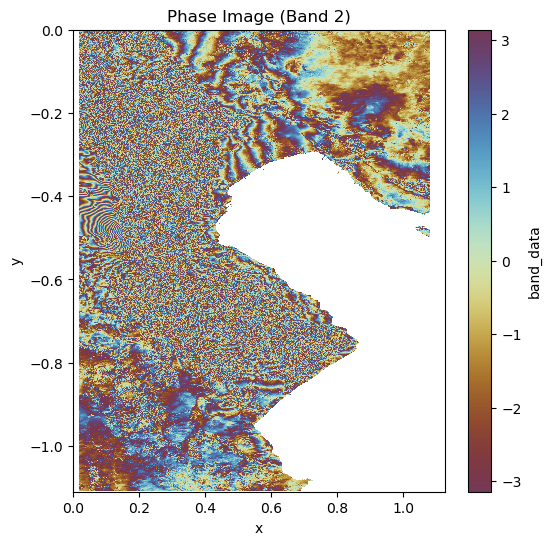

In [4]:
# Plot Phase Image
fig, axs = plt.subplots(figsize=(6, 6))

(origin.sel(band=2).where(mask)
       .plot.imshow(cmap=cmap_cyc, zorder=1)
       .axes.set_title("Phase Image (Band 2)"))
plt.show()

In [5]:

# Set the intensity and phase from the bands
def turn_complex(data, intensity_band=1, phase_band=2):
    intensity = data.sel(band=intensity_band)
    phase = data.sel(band=phase_band)

    # Convert Polar Coordinates to Cartesian Coordinates
    # Snaphu requires complex numbers
    x = np.sqrt(intensity) * np.cos(phase)
    y = np.sqrt(intensity) * np.sin(phase)
    igram = x + y * 1j
    return igram

cmplx = turn_complex(origin)

In [10]:
cmplx

<xarray.DataArray 'band_data' (y: 12250, x: 4188)> Size: 410MB
array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       ...,
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]],
      dtype=complex64)
Coordinates:
  * x            (x) float64 34kB 0.0001344 0.0004033 0.0006722 ... 1.126 1.126
  * y            (y) float64 98kB -4.531e-05 -0.0001359 ... -1.11 -1.11
    spatial_ref  int64 8B 0

In [13]:
filename_cmplx = "S1A_IW_SLC__1SDV_20230129T033452_20230129T033519_046993_05A2FE_BE0B_Orb_Stack_IW3_ifg_deb_dinsar_ML_flt_cmplx.tif"
path = src / filename_cmplx


cmplx.rio.to_raster(path,
                    tiled=True,
                    driver="GTiff",
                    compress="LZW")

In [20]:
loaded_data = xr.open_dataset(path, engine='rasterio')
loaded_data = loaded_data.band_data.sel(band=1)#.compute()

In [21]:
loaded_data#.compute()

<xarray.DataArray 'band_data' (y: 12250, x: 4188)> Size: 410MB
[51303000 values with dtype=complex64]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 34kB 0.0001344 0.0004033 0.0006722 ... 1.126 1.126
  * y            (y) float64 98kB -4.531e-05 -0.0001359 ... -1.11 -1.11
    spatial_ref  int64 8B ...
Attributes:
    AREA_OR_POINT:  Area
    long_name:      band_data

## Unwrapping Algorithm

As we will be doing the unwrapping multiple times in this notebook lets create a function that does the unwrapping for us on `xarray DataArray` objects.
The actual core function where the unwrapping is happening is `snaphu.unwrap_phase` from the `snaphu` package. This function needs a 2D numpy array as input, where each pixel value is a complex number.
Therefore we have to convert the `xarray DataArray` to a 2D numpy array with complex values. We do that by combining the phase and intensity bands to a complex array.

In [5]:
def unwrap_data(data: xr.DataArray,
                mask: xr.DataArray = True,
                phase_band: int = 2,
                intensity_band: int = 1,
                coherence_band: int = 3,
                mask_nodata_value: int = 0,
                coh_low_threshold: float = None,
                coh_high_threshold: float = None,
                **kwargs) -> xr.DataArray:
    """
    Unwraps the phase data using the snaphu algorithm

    :param data: xarray DataArray with phase, intensity and coherence bands
    :type data: xr.DataArray
    :param mask: xarray DataArray with mask values
    :type mask: xr.DataArray | bool
    :param phase_band: Band number of the phase data
    :type phase_band: int
    :param intensity_band: Band number of the intensity data
    :type intensity_band: int
    :param coherence_band: Band number of the coherence data
    :type coherence_band: int
    :param mask_nodata_value: Value of the no data pixels in the mask
    :param coh_low_threshold: Lower threshold for the coherence values
    :param coh_high_threshold: Higher threshold for the coherence values

    :return: xarray DataArray with the unwrapped phase
    :rtype: xr.DataArray
    """

    # Create a mask for the areas which have a lot of no data
    if mask is True:
        phase_data = data.sel(band=phase_band)
        mask = (data.sel(band=phase_band)
                .where(phase_data == mask_nodata_value, True, False)
                .astype(bool))

    elif type(mask) == xr.DataArray:
        mask = mask

    if coh_low_threshold is not None:
        coh = data.sel(band=coherence_band)
        coh_mask = (coh.where(coh >= coh_low_threshold, False, True)
                    .astype(bool))
        mask = mask & coh_mask

    elif coh_high_threshold is not None:
        coh = data.sel(band=coherence_band)
        coh_mask = (coh.where(coh <= coh_high_threshold, False, True)
                    .astype(bool))
        mask = mask & coh_mask

    # Apply the mask to the data
    data = data.where(mask)

    # Set the intensity and phase from the bands
    intensity = data.sel(band=intensity_band)
    phase = data.sel(band=phase_band)
    coh = data.sel(band=coherence_band)

    # Convert Polar Coordinates to Cartesian Coordinates
    # Snaphu requires complex numbers
    x = np.sqrt(intensity) * np.cos(phase)
    y = np.sqrt(intensity) * np.sin(phase)
    igram = x + y * 1j

    # Unwrap the phase
    unw, _ = snaphu.unwrap(igram,
                           coh, nlooks=1.0,
                           cost="smooth", init="mcf",
                           mask=mask, **kwargs)

    # Build xarray Dataset with the unwrapped phase
    unw_da = xr.DataArray(unw, coords=phase.coords, dims=phase.dims)

    # Mask the unwrapped phase
    unw_da = unw_da.where(mask)
    return unw_da

## Unwrapping on a Subset

As the original image is too large to unwrap in a reasonable time, we will unwrap a subset of the image. In this case we will unwrap an area of 500x500 pixels.

In [26]:
# Select a subset of the data
x_dx, y_dy = 500, 500
x_0, y_0 = 200, 5600
subset = origin.isel(x=slice(x_0, x_0 + x_dx), y=slice(y_0, y_0 + y_dy))

# Unwrap the subset
unwrapped_subset = unwrap_data(subset)


snaphu v2.0.7
23 parameters input from file /tmp/tmpd90ounjp/snaphu.config.y3ouybsn.txt (23 lines total)
Reading wrapped phase from file /tmp/tmpd90ounjp/snaphu.igram.pzjl79uj.c8
Reading byte mask from file /tmp/tmpd90ounjp/snaphu.mask.0il2sp5g.u1
No weight file specified.  Assuming uniform weights
Reading correlation data from file /tmp/tmpd90ounjp/snaphu.corr.qp4uo7pw.f4
Calculating smooth-solution cost parameters
Initializing flows with MCF algorithm
Running nonlinear network flow optimizer
Maximum flow on network: 2
Flow increment: 1  (Total improvements: 0)
Found 1 valid set(s) of connected nodes
Growing connected component mask
Writing connected components to file /tmp/tmpd90ounjp/snaphu.conncomp.hy4ls3s2.u4 as 4-byte unsigned ints
Maximum flow on network: 1
Total solution cost: 4266810
Integrating phase
Writing output to file /tmp/tmpd90ounjp/snaphu.unw.8hoc61zj.f4
Program snaphu done
Elapsed processor time:   0:00:02.12
Elapsed wall clock time:  0:00:02


Now lets compare the wrapped and unwrapped phase images, to see what has happend.

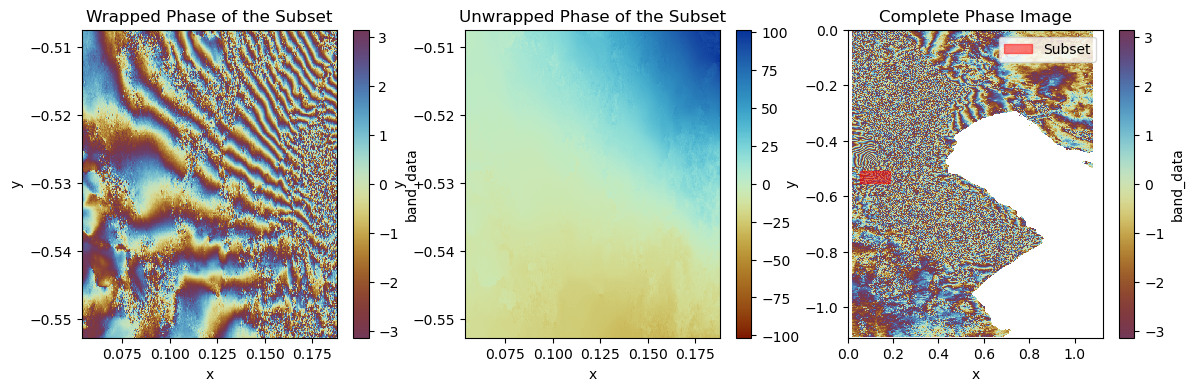

In [32]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
(subset.sel(band=2)
 .where(subset.sel(band=2) != 0)
 .plot.imshow(cmap=cmap_cyc, ax=axs[0])
 .axes.set_title("Wrapped Phase of the Subset"))

(unwrapped_subset.plot.imshow(cmap=cmap_lin, ax=axs[1])
 .axes.set_title("Unwrapped Phase of the Subset"))

(origin.sel(band=2).where(mask)
       .plot.imshow(cmap=cmap_cyc, zorder=1, ax=axs[2])
       .axes.set_title("Complete Phase Image"))

x_start = origin.coords['x'][x_0].item()
y_start = origin.coords['y'][y_0].item()
x_end = origin.coords['x'][x_0 + x_dx].item()
y_end = origin.coords['y'][y_0 + y_dy].item()

rect = patches.Rectangle((x_start, y_start),
                         x_end-x_start, y_end-y_start,
                         linewidth=1, edgecolor='r',
                         facecolor='red', alpha=0.5,
                         label='Subset')

# Add the rectangle to the plot
axs[2].add_patch(rect)
axs[2].legend()
plt.show()

## Unwrapping with coherence mask
Additionally can we try to calculate the unwrapped image, where we are excluding pixels, where the coherence values are lower than a certain threshold. This is done by masking the coherence image with the threshold value and then unwrapping the phase image with the masked coherence image.

In [33]:
unwrapped_coh = unwrap_data(subset, coh_high_threshold=0.3)


snaphu v2.0.7
23 parameters input from file /tmp/tmpg77d6sqn/snaphu.config.2qms_avs.txt (23 lines total)
Reading wrapped phase from file /tmp/tmpg77d6sqn/snaphu.igram.teqvufer.c8
Reading byte mask from file /tmp/tmpg77d6sqn/snaphu.mask.90azq3d2.u1
No weight file specified.  Assuming uniform weights
Reading correlation data from file /tmp/tmpg77d6sqn/snaphu.corr.dmfbgg5l.f4
Calculating smooth-solution cost parameters
Initializing flows with MCF algorithm
Running nonlinear network flow optimizer
Maximum flow on network: 3
Flow increment: 1  (Total improvements: 0)
Found 4613 valid set(s) of connected nodes
Growing connected component mask
Writing connected components to file /tmp/tmpg77d6sqn/snaphu.conncomp.nhbi52yc.u4 as 4-byte unsigned ints
Maximum flow on network: 1
Total solution cost: 962552
Integrating phase
Writing output to file /tmp/tmpg77d6sqn/snaphu.unw.pewwov30.f4
Program snaphu done
Elapsed processor time:   0:00:07.59
Elapsed wall clock time:  0:00:07


Lets compare the unwrapped image with and without the coherence mask.

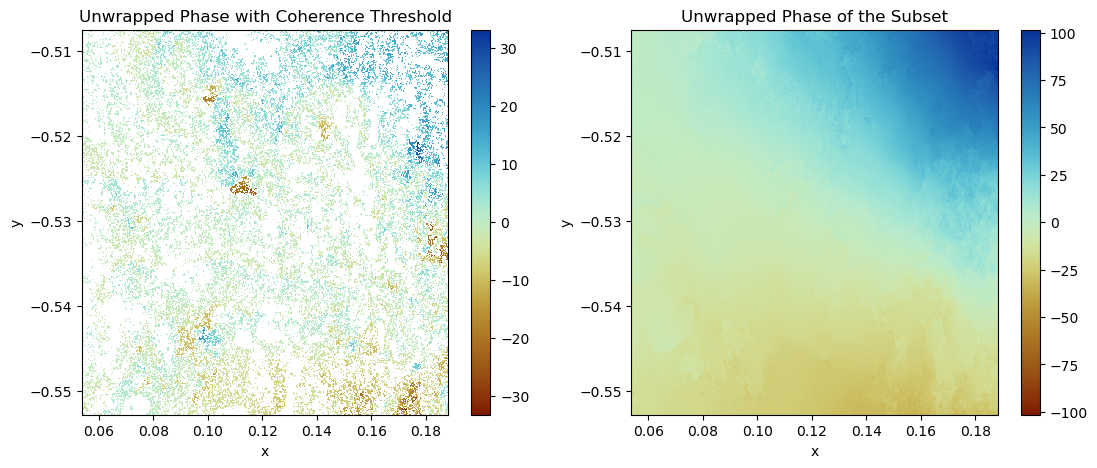

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(13, 5))
(unwrapped_coh.plot.imshow(cmap=cmap_lin, ax=axs[0])
 .axes.set_title("Unwrapped Phase with Coherence Threshold"))

(unwrapped_subset.plot.imshow(cmap=cmap_lin, ax=axs[1])
 .axes.set_title("Unwrapped Phase of the Subset"))

plt.show()

We can see quite a difference between the two images. The unwrapped image with the coherence mask has many gaps. We can fill these gaps by interpolating the unwrapped image.

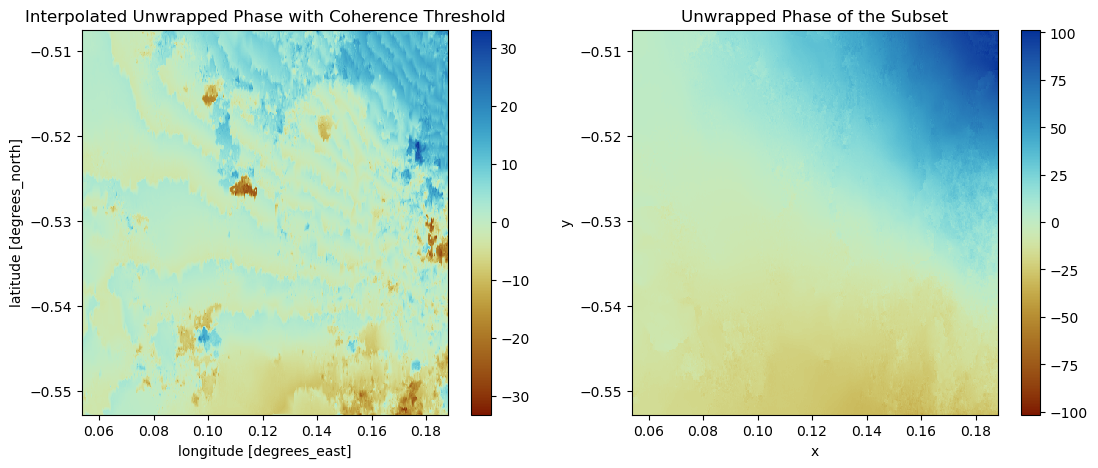

In [34]:
# Interpolate the no data values
filled_coh = unwrapped_coh.rio.write_nodata(np.nan)
filled_coh = filled_coh.rio.interpolate_na(method='linear')

fig, axs = plt.subplots(1, 2, figsize=(13, 5))

(filled_coh.plot.imshow(cmap=cmap_lin, ax=axs[0])
 .axes.set_title("Interpolated Unwrapped Phase with Coherence Threshold"))

(unwrapped_subset.plot.imshow(cmap=cmap_lin, ax=axs[1])
 .axes.set_title("Unwrapped Phase of the Subset"))

plt.show()

Lets see if another threshold value for the coherence mask gives better results.


snaphu v2.0.7
23 parameters input from file /tmp/tmpmh_840xw/snaphu.config.1dk2ec4w.txt (23 lines total)
Reading wrapped phase from file /tmp/tmpmh_840xw/snaphu.igram.4vxjchsd.c8
Reading byte mask from file /tmp/tmpmh_840xw/snaphu.mask.j4qlcn4y.u1
No weight file specified.  Assuming uniform weights
Reading correlation data from file /tmp/tmpmh_840xw/snaphu.corr.qmt57h98.f4
Calculating smooth-solution cost parameters
Initializing flows with MCF algorithm
Running nonlinear network flow optimizer
Maximum flow on network: 2
Flow increment: 1  (Total improvements: 0)
Found 655 valid set(s) of connected nodes
Growing connected component mask
Writing connected components to file /tmp/tmpmh_840xw/snaphu.conncomp.qixmpa5h.u4 as 4-byte unsigned ints
Maximum flow on network: 1
Total solution cost: 3378709
Integrating phase
Writing output to file /tmp/tmpmh_840xw/snaphu.unw.8p1ookou.f4
Program snaphu done
Elapsed processor time:   0:00:04.53
Elapsed wall clock time:  0:00:05


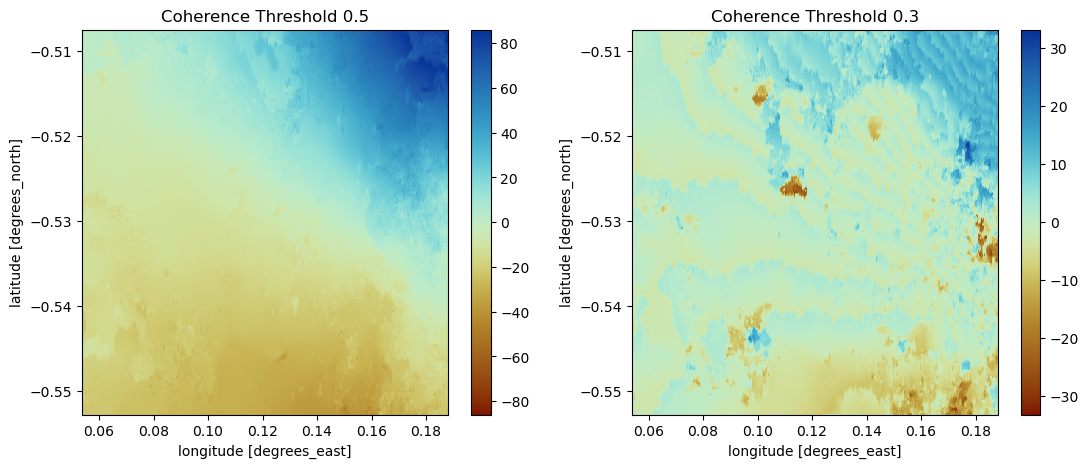

In [39]:
unwrapped_coh2 = unwrap_data(subset, coh_high_threshold=0.5)

# Interpolate the no data values
filled_coh2 = unwrapped_coh2.rio.write_nodata(np.nan)
filled_coh2 = filled_coh2.rio.interpolate_na(method='linear')

fig, axs = plt.subplots(1, 2, figsize=(13, 5))
(filled_coh2.plot.imshow(cmap=cmap_lin, ax=axs[0])
 .axes.set_title("Coherence Threshold 0.5"))

(filled_coh.plot.imshow(cmap=cmap_lin, ax=axs[1])
 .axes.set_title("Coherence Threshold 0.3"))
plt.show()

## Applying equation for displacement map

From the unwrapped phase image we can calculate the displacement map using the following equation:

$
d = - \frac{\lambda}{4 \cdot \pi} \cdot \Delta \phi_d
$

where:
- $\lambda = 0.056$ for Sentinel-1
- $\Delta \phi_d$ is the unwrapped image

This operation can be very useful for monitoring ground deformation.

In [41]:
def displacement(unw, lambda_val: float = 0.056) -> xr.DataArray:
    """
    Calculates the displacement from the unwrapped phase

    :param unw: xarray DataArray with the unwrapped phase
    :type unw: xr.DataArray
    :param lambda_val: Wavelength of the radar signal
    :type lambda_val: float

    :return: xarray DataArray with the displacement
    :rtype: xr.DataArray
    """
    disp = unw * - lambda_val / (4 * np.pi)
    return disp


# Calculate the displacement
disp_subset = displacement(unwrapped_subset)

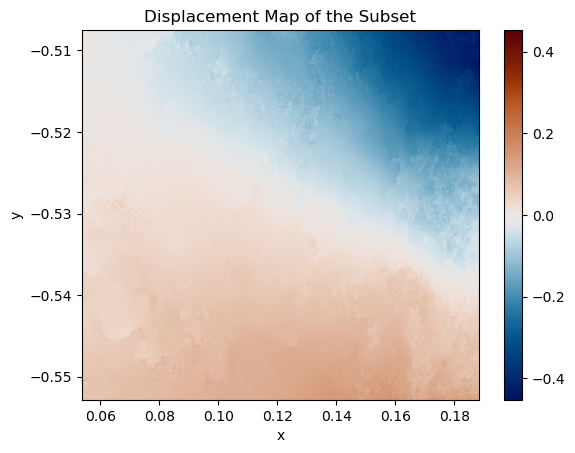

In [42]:
# Plot the displacement map
(disp_subset.plot.imshow(cmap=cmap_disp)
 .axes.set_title("Displacement Map of the Subset"))
plt.show()

## Geocoding the image

The last step would be to geocode the image from radar geometry to latlon. Here we only have an already geocoded image, so we will skip this step.

Text(0.5, 1.0, 'Low Coherence Image')

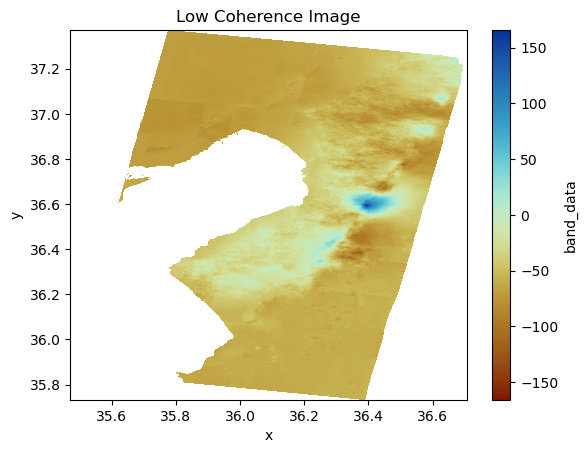

In [17]:
(lowcoh.sel(band=1).where(mask_lowcoh).plot.imshow(cmap=cmap_lin)
 .axes.set_title("Low Coherence Image"))

Text(0.5, 1.0, 'Displacement Map of enitre Scene')

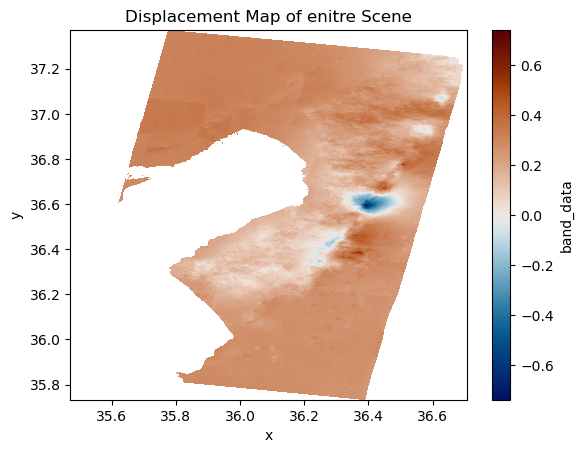

In [18]:
total_displacement = displacement(lowcoh.sel(band=1).where(mask_lowcoh))

# Plot the displacement map
(total_displacement.plot.imshow(cmap=cmap_disp)
 .axes.set_title("Displacement Map of enitre Scene"))

## Coarsen approach

As the whole data is too large and the processing time is already exceeds 20 minutes when useing a image with 4000x4000 pixels, we can coarsen the image.

In [19]:
kernel_size = 3
lowres = origin.coarsen(x=kernel_size, y=kernel_size, boundary="trim").median()

In [20]:
unwrapped_lowres = unwrap_data(lowres, ntiles=(20, 30), tile_overlap=10)


snaphu v2.0.7
24 parameters input from file /tmp/tmpvi8fsrnj/snaphu.config.qk4eu6pb.txt (24 lines total)
Starting first-round tile-mode unwrapping
Creating temporary directory /tmp/tmpvi8fsrnj/snaphu_tiles_45988
Unwrapping tile at row 0, column 0
Reading wrapped phase from file /tmp/tmpvi8fsrnj/snaphu.igram.k3eat2v_.c8
Reading byte mask from file /tmp/tmpvi8fsrnj/snaphu.mask.4ym5myn4.u1
No weight file specified.  Assuming uniform weights
Reading correlation data from file /tmp/tmpvi8fsrnj/snaphu.corr.hfzbljlr.f4
Calculating smooth-solution cost parameters
Initializing flows with MCF algorithm
Running nonlinear network flow optimizer
Maximum flow on network: 1
Flow increment: 1  (Total improvements: 0)
Found 1 valid set(s) of connected nodes
Growing connected component mask
Writing connected components to file /tmp/tmpvi8fsrnj/snaphu_tiles_45988/tmptile_snaphu.conncomp.vwgcscdm.u4_0_0.57 as 4-byte unsigned ints
Growing reliable regions
Maximum flow on network: 1
Total solution cost: 36

We can plot the unwrapped image of the low resolution image and compare it to the unwrapped image of the high resolution and geocoded image.

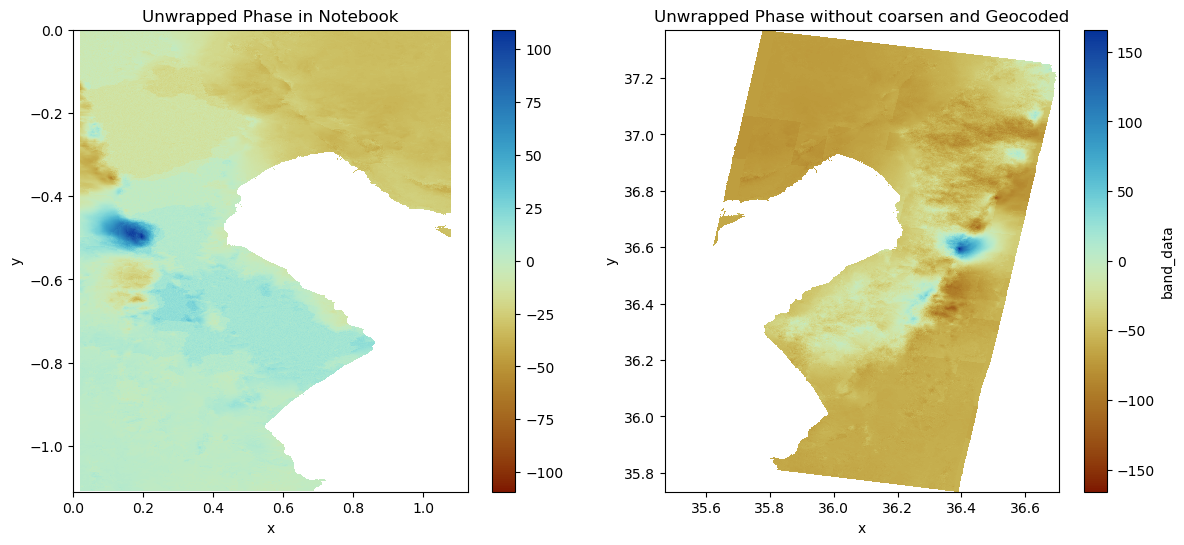

In [22]:
# Plot the unwrapped phase
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
(unwrapped_lowres.plot.imshow(ax=axs[0], cmap=cmap_lin)
 .axes.set_title("Unwrapped Phase in Notebook"))

(lowcoh.squeeze().where(lowcoh.squeeze() != 0)
 .plot.imshow(ax=axs[1], cmap=cmap_lin)
 .axes.set_title("Unwrapped Phase without coarsen and Geocoded"))
plt.show()

From both we can also calculate the displacement map and compare them.

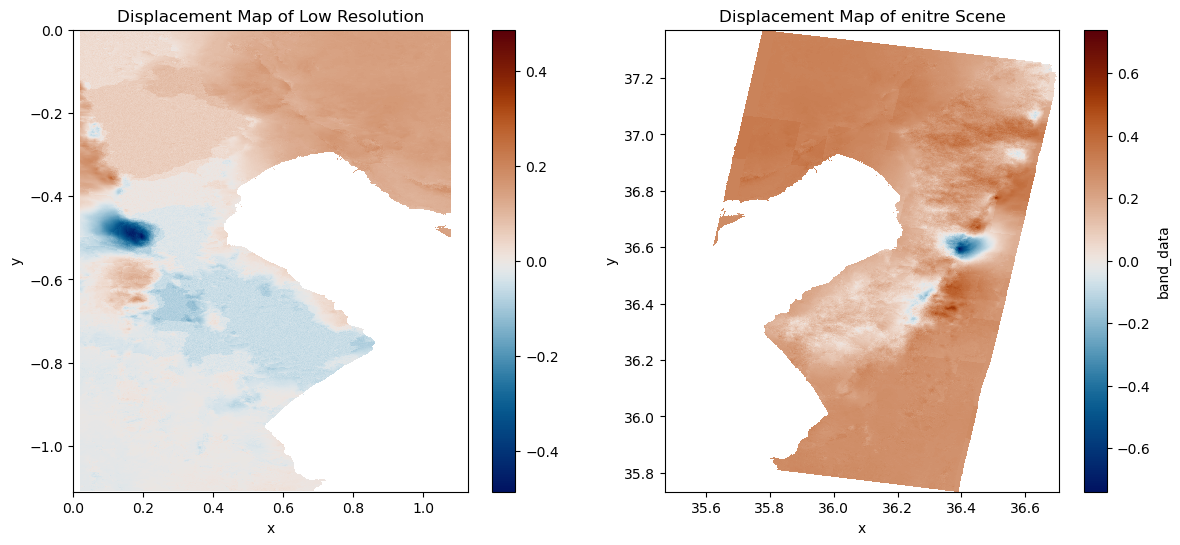

In [44]:
lowres_disp = displacement(unwrapped_lowres)

total_displacement = displacement(lowcoh.sel(band=1).where(mask_lowcoh))

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
# Plot the displacement map
(total_displacement.plot.imshow(cmap=cmap_disp, ax=axs[1])
 .axes.set_title("Displacement Map of enitre Scene"))

# Plot the displacement map
(lowres_disp.plot.imshow(cmap=cmap_disp, ax=axs[0])
 .axes.set_title("Displacement Map of Low Resolution"))
plt.show()